In [1]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [2]:
review_train = pd.read_csv('../data/reviews_train.csv', encoding='utf-8')

In [3]:
review_train.head()

,text,label
0,"Хороший магазин для спокойной, неторопливой по...",1
1,В этом магазине заоблачные цены!!! Например тр...,-1
2,"Всем рекомендую этот ПАБ!!!!Бываем не часто, ...",1
3,"заказал соковыжималку и пылесос борк, позвонил...",1
4,Принимают заказ.Ждёшь три дня.Доставка не появ...,-1


In [4]:
texts, labels = review_train.text.values, review_train.label.values

### Reading vocabulary and embeddings

In [5]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [6]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Яa-zA-Z]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

Заказывал принтер сетевой по безналичной оплате с доставкой в Самару. Доставили через 4 дня после оплаты. Всем доволен.
Заказывал принтер сетевой по безналичной оплате с доставкой в Самару Доставили через дня после оплаты Всем доволен
заказывать принтер сетевой по безналичный оплата с доставка в самар доставить через день после оплата весь довольный
[5814, 9452, 6700, 17, 30383, 2409, 8, 5692, 2, 7312, 4145, 183, 132, 117, 2409, 11, 2123, 0]


Dumping

Loading

In [8]:
X = cPickle.load(open('../data/X_review_train.pkl', 'rb'))

Distribution of sequences' lengths 

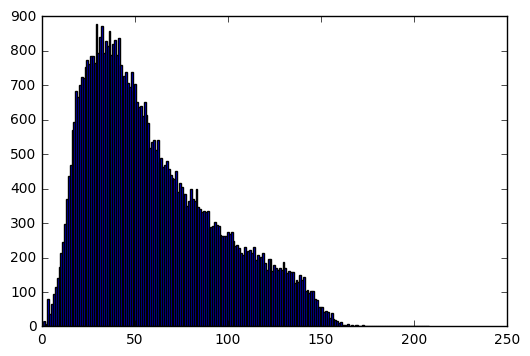

In [9]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=length_max);

Drop samples with the length > 150

In [10]:
length_max = 150
y = review_train.label.values
y = y[np.array(map(len, X)) <= length_max]
X = [x for x in X if len(x) <= length_max]

### Zero padding

In [11]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [12]:
for x in X[:3]:
    print x

[65, 869, 43, 2135, 37924, 2799, 11, 1100, 802, 342, 1, 514, 373, 2, 2293, 127, 43, 10, 53, 151, 8, 4434, 7611, 78, 32611, 1038, 9653, 5, 29, 869, 2, 413, 582, 9, 1475, 2, 460, 1270, 1, 10, 7611, 827, 14, 2197, 8122, 11, 1475, 241, 9626, 59, 756, 1, 11, 67, 394, 1270, 704, 703, 5, 162, 35, 1, 48, 35, 96, 151, 133, 9, 57, 382, 9, 3, 637, 68, 194, 1270, 12, 4, 137, 221, 9, 291, 11898, 22, 2, 2332, 115, 43011, 7, 78, 5763, 1, 25, 1131, 1, 2729, 449, 489, 162, 1270, 48, 57, 194, 263, 3205, 5, 29, 869, 103, 48, 11, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 7, 869, 15574, 217, 222, 901, 3705, 78611, 206, 197, 6, 2, 413, 645, 15, 206, 429, 197, 222, 5, 62, 21530, 2795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Split into train and validation sets

In [13]:
X = np.array(X)

In [14]:
def cls2probs(cls):
    if cls == -1:
        return [1.,0.]
    else:
        return [0.,1.]
y = np.array([cls2probs(cls) for cls in y])

In [15]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=40)

In [16]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[10840, 42049]
Validation class frequencies:	[1209, 4668]
Constant classifier's validation accuracy:	0.794282797346


### Resampling

# Network learning

In [17]:
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import LSTMCell, GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.layers import fully_connected

from utils import *

In [37]:
from sklearn.metrics import f1_score
f_macro = lambda y1, y2: f1_score(y1, y2, average="macro")
f_micro = lambda y1, y2: f1_score(y1, y2, average="micro")

y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,1] = 1.
print "Constant classifier's macro-averaged F-score on validation set:", f_macro(y_val, y_pred_major)
print "Constant classifier's micro-averaged F-score on validation set:", f_micro(y_val, y_pred_major)

Constant classifier's macro-averaged F-score on validation set: 0.442674253201
Constant classifier's micro-averaged F-score on validation set: 0.794282797346


### Bi-RNN

In [40]:
EMBED_DIM = 300
HIDDEN_SIZE = 600
NUM_CLASSES = 2

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, None])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)
batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
    
# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Last output of Bi-RNN
output = outputs[:,0,:]

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [41]:
# Adam parameters
LEARNING_RATE = 9e-5
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
# optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
#                                    epsilon=EPSILON).minimize(loss)
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 14
	 Train loss: 0.211	 ce: 0.211	 acc: 0.906	 f_macro: 0.835
	 Valid loss: 0.247	 ce: 0.247	 acc: 0.892	 f_macro: 0.830


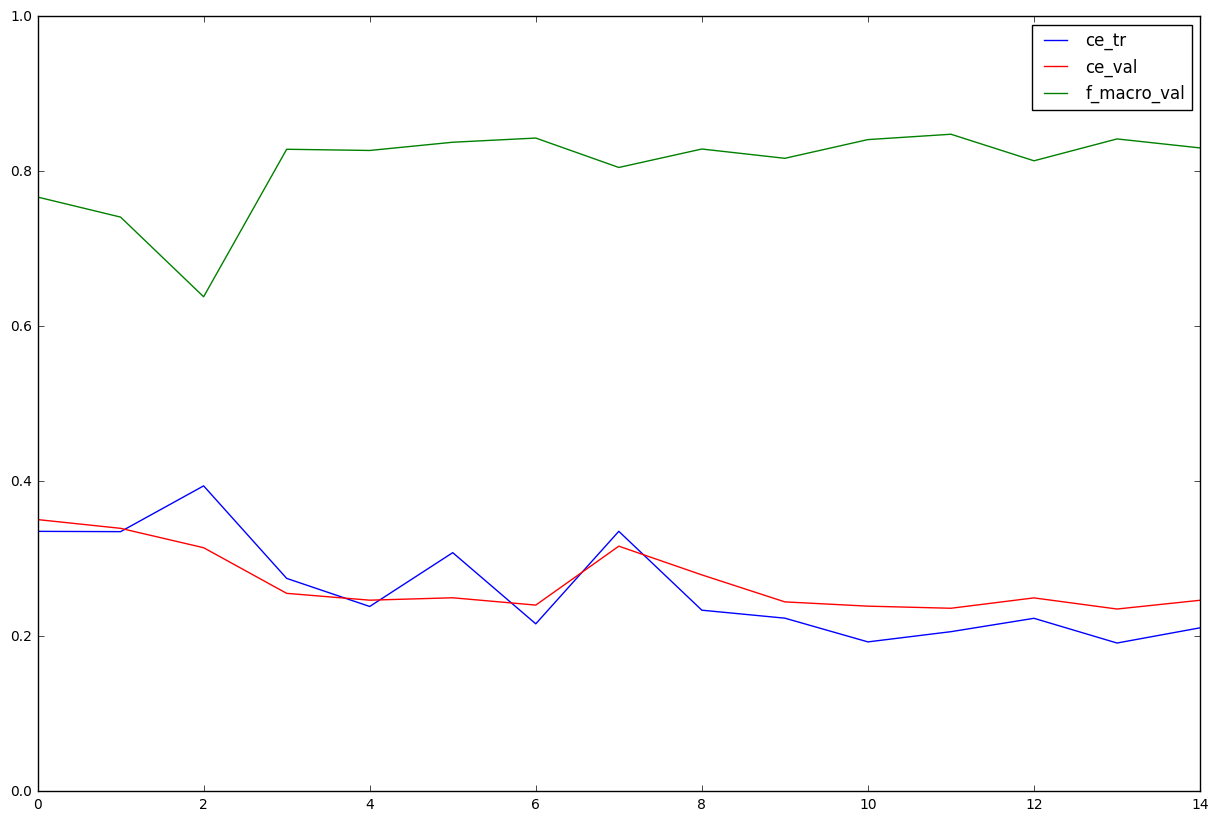

In [42]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 15

skf = KFold(10, shuffle=True, random_state=42)

results = []

for train_index, test_index in skf.split(X, y):
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []
    min_ce = 0.32

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            
            y_pred_val, ce_val, loss_val, acc_val = [], 0, 0, 0
            num_val_batches = X_val.shape[0] / BATCH_SIZE
            for i in range(num_val_batches):
                x_batch_val, y_batch_val = X_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                           y_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
                seq_len_val = np.array([list(x).index(eos_id) + 1 for x in x_batch_val])
                y_pred_val_, ce_val_, loss_val_, acc_val_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: x_batch_val, target_ph: y_batch_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})
                y_pred_val += list(y_pred_val_)
                ce_val += ce_val_
                loss_val += loss_val_
                acc_val += acc_val_
            
            y_pred_val = np.array(y_pred_val)
            ce_val /= num_val_batches
            loss_val /= num_val_batches
            acc_val /= num_val_batches

            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val),\
                                       f_micro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val)
        

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results.append([acc_val_l[-1], f_macro_val_l[-1]])

In [43]:
results

[[0.88494318181818177, 0.8138848725974327],
 [0.88849431818181823, 0.81580566170780311],
 [0.88760653409090906, 0.83018528471192843],
 [0.890625, 0.83915157559789522],
 [0.89133522727272729, 0.83885722556745723],
 [0.88760653409090906, 0.84126787795405744],
 [0.87127130681818177, 0.78292137997397626],
 [0.89009232954545459, 0.84911586349029067],
 [0.89293323863636365, 0.84268546296808844],
 [0.89204545454545459, 0.83036991653080106]]

In [47]:
# hid 600, ep 15, mom 0.1
results = np.array([[0.88494318181818177, 0.8138848725974327],
 [0.88849431818181823, 0.81580566170780311],
 [0.88760653409090906, 0.83018528471192843],
 [0.890625, 0.83915157559789522],
 [0.89133522727272729, 0.83885722556745723],
 [0.88760653409090906, 0.84126787795405744],
 [0.87127130681818177, 0.78292137997397626],
 [0.89009232954545459, 0.84911586349029067],
 [0.89293323863636365, 0.84268546296808844],
 [0.89204545454545459, 0.83036991653080106]])
print results.mean(axis=0)
print results.std(axis=0)

[ 0.88769531  0.82842451]
[ 0.00593223  0.01862371]


In [50]:
# hid 300, ep 20, mom 0.1
results = np.array([[0.876953125, 0.7954565071460431],
 [0.89825994318181823, 0.85424219319624717],
 [0.884765625, 0.83369561453880314],
 [0.88245738636363635, 0.83322538234332133],
 [0.876953125, 0.82933183329828553],
 [0.87198153409090906, 0.8244311830735741],
 [0.89240056818181823, 0.8371743670538232],
 [0.89754971590909094, 0.8462601032340048],
 [0.89985795454545459, 0.84855407659145987],
 [0.89346590909090906, 0.84153994363863904]])
print results.mean(axis=0)
print results.std(axis=0)

[ 0.88746449  0.83439112]
[ 0.00961919  0.01561065]


Something strange happens here. When validation loss starts increasing (overfitting appears) validation metrics (accuracy and f-score) keep going up for some time.

---

### Bi-RNN with Attention mechanism

Attention mechanism formulas and notation
$$
\upsilon_{t}=\tanh{(W_{\omega}\left[\overrightarrow{h_{t}},\overleftarrow{h_{t}}\right]+b_{\omega})}\\
\alpha_{t}=\frac{\exp{(\upsilon_{t}^{T}u_{\omega})}}{\sum_{j=1}^{T}\exp{(\upsilon_{j}^{T}u_{\omega})}}\\
\upsilon=\sum_{t=1}^{T}\alpha_{t}h_{t}	
$$

In [44]:
EMBED_DIM = 300
SEQ_LENGTH = length_max
HIDDEN_SIZE = 600
ATTENTION_SIZE = 100
NUM_CLASSES = 2

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, SEQ_LENGTH])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)

batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)

# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Attention mechanism
W_omega = tf.Variable(tf.random_normal([2 * HIDDEN_SIZE, ATTENTION_SIZE], stddev=0.1))
b_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))
u_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))

v = tf.tanh(tf.matmul(tf.reshape(outputs, [-1, 2 * HIDDEN_SIZE]), W_omega) + tf.reshape(b_omega, [1, -1]))
vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
exps = tf.reshape(tf.exp(vu), [-1, SEQ_LENGTH])
alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

# Output of Bi-RNN reduced with attention vector
output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [45]:
# Adam parameters
LEARNING_RATE = 1e-1
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
# optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
#                                    epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=LEARNING_RATE, rho=0.7).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.1).minimize(loss)
optimizer = tf.train.MomentumOptimizer(learning_rate=LEARNING_RATE, momentum=0.1).minimize(loss)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.9, momentum=0.1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

In [324]:
min(ce_val_l), max(acc_val_l), max(f_macro_val_l)

(0.24238382, 0.92178774, 0.8276723276723278)

In [46]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 15

skf = KFold(10, shuffle=True, random_state=42)

results_att = []

for train_index, test_index in skf.split(X, y):
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []
    min_ce = 0.32

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            
            y_pred_val, ce_val, loss_val, acc_val = [], 0, 0, 0
            num_val_batches = X_val.shape[0] / BATCH_SIZE
            for i in range(num_val_batches):
                x_batch_val, y_batch_val = X_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                           y_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
                seq_len_val = np.array([list(x).index(eos_id) + 1 for x in x_batch_val])
                y_pred_val_, ce_val_, loss_val_, acc_val_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: x_batch_val, target_ph: y_batch_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})
                y_pred_val += list(y_pred_val_)
                ce_val += ce_val_
                loss_val += loss_val_
                acc_val += acc_val_
            
            y_pred_val = np.array(y_pred_val)
            ce_val /= num_val_batches
            loss_val /= num_val_batches
            acc_val /= num_val_batches

            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val),\
                                       f_micro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val)
        

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results_att.append([acc_val_l[-1], f_macro_val_l[-1]])

Start learning...


ResourceExhaustedError: OOM when allocating tensor with shape[256,150,1200]
	 [[Node: gradients/mul_grad/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](concat, gradients/Sum_1_grad/Tile)]]

Caused by op u'gradients/mul_grad/mul_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-d0d0b7307512>", line 16, in <module>
    optimizer = tf.train.MomentumOptimizer(learning_rate=LEARNING_RATE, momentum=0.1).minimize(loss)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 196, in minimize
    grad_loss=grad_loss)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 253, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py", line 469, in gradients
    in_grads = _AsList(grad_fn(op, *out_grads))
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py", line 583, in _MulGrad
    array_ops.reshape(math_ops.reduce_sum(x * grad, ry), sy))
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 751, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 910, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1519, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'mul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-79875598c8d3>", line 39, in <module>
    output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 751, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 910, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1519, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ilya/.virtualenvs/nlp/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,150,1200]
	 [[Node: gradients/mul_grad/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](concat, gradients/Sum_1_grad/Tile)]]


In [ ]:
results_att

In [51]:
# hid 300, att 100, ep 20, mom 0.1
results_att = np.array([[0.8984375, 0.8456319971049866],
 [0.90216619318181823, 0.85775310250843251],
 [0.88796164772727271, 0.83567111861850241],
 [0.89506392045454541, 0.84517551479479014],
 [0.89115767045454541, 0.84229205535978169],
 [0.89026988636363635, 0.82472930194183913],
 [0.89453125, 0.84119191133579618],
 [0.89719460227272729, 0.85409524233946188],
 [0.89932528409090906, 0.83969316772387659],
 [0.90003551136363635, 0.85215848318017495]])
print results_att.mean(axis=0)
print results_att.std(axis=0)

[ 0.89561435  0.84383919]
[ 0.00441788  0.00911861]


In [52]:
# hid 100, att 100, ep 20, Momentum 0.1
results_att = np.array([[0.89453125, 0.83472022955523673],
 [0.88263494318181823, 0.80009132080241807],
 [0.88973721590909094, 0.82726533023206872],
 [0.88742897727272729, 0.81725631859116521],
 [0.89328835227272729, 0.83723951439862265],
 [0.89577414772727271, 0.84819626582128804],
 [0.87748579545454541, 0.79626605197530842],
 [0.88778409090909094, 0.81226904300789449],
 [0.90021306818181823, 0.8481388616210439],
 [0.89044744318181823, 0.85117996914343597]])
print results_att.mean(axis=0)
print results_att.std(axis=0)

[ 0.88993253  0.82726229]
[ 0.00625769  0.01904003]


---

---

---

# Testing

In [250]:
review_test = pd.read_csv('../data/review_test.csv', sep='\t', encoding='utf-8')
texts_test, labels_test = review_test.text.values, review_test.label.values

In [263]:
%%time
pool = multiprocessing.Pool()
X_test = pool.map(text2seq, texts_test)
cPickle.dump(X_test, open('../data/X_review_test.pkl', 'wb'))

CPU times: user 272 ms, sys: 728 ms, total: 1 s
Wall time: 39 s


In [254]:
X_test = cPickle.load(open('../data/X_review_test.pkl', 'rb'))

In [274]:
X_test = [x + [eos_id]*(length_max - len(x)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [292]:
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((537, 29), (537, 3), (3418, 29), (3418, 3))

In [352]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_birnn_momentum.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in X_test])
    y_pred_test, ce_test, loss_test, acc_test = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: X_test, target_ph: y_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
    seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
    y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})

In [353]:
y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)
print f_macro_val, f_micro_val

0.629508196721 0.794366197183


In [354]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test, f_micro_test = f_macro(y_test, y_pred_test), f_micro(y_test, y_pred_test)
print f_macro_test, f_micro_test

0.434433507829 0.522274881517
